In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
df = pd.read_excel('../data/combined_results_ms.xlsx')
df.Dataset = df.Dataset.apply(lambda x: "300Da" if x == "Alasdair" else "rest")
df.head()

,Unnamed: 0,sample_id,# MS2 peaks,# MS3 peaks,# MS4 peaks,# MS5 peaks,Parent m/z,MA (lower est.),MA (upper est.),MA (mean est.),MA (est.),MA (MW est.),formula,MW,CAS,SMILES,Dataset,MA,Error
0,0,150523/CAS_100442_33_9,26,29,106,0,298.2165,14.516127,22.899066,17.374832,[17.47908389 14.96996731 17.13054932 17.334126...,20.966554,C20H27NO,297.44,100442-33-9,CN(CCC(c1ccccc1)c1ccccc1)CC(C)(C)O,300Da,12,5.374832
1,1,150523/CAS_1306606_88_1,45,129,113,0,305.0565,13.015707,22.146541,18.324900,[18.78917388 18.87812938 19.62279599 18.953457...,20.578473,C12H11F3N2O2S,304.29,1306606-88-1,CCc1ccc2nc(NC(=O)OCC(F)(F)F)sc2c1,300Da,18,0.324900
2,2,150523/CAS_1306606_88_1,45,129,113,0,305.0565,13.015707,22.146541,18.324900,[18.78917388 18.87812938 19.62279599 18.953457...,20.578473,C12H11F3N2O2S,304.29,1306606-88-1,CCc1ccc2nc(NC(=O)OCC(F)(F)F)sc2c1,300Da,18,0.324900
3,3,150523/CAS_13139_14_5,27,108,106,0,305.1495,12.041205,24.721444,18.323225,[16.35932194 15.93120897 15.11849972 24.721443...,21.470851,C16H20N2O4,304.34,13139-14-5,CC(C)(C)OC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)O,300Da,15,3.323225
4,4,150523/CAS_146_77_0,13,37,37,0,302.0650,14.433475,23.903061,19.027920,[19.1896747 22.31284487 18.57215271 18.447666...,21.981289,C10H12ClN5O4,301.69,146-77-0,Nc1nc(Cl)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C...,300Da,14,5.027920


In [3]:
def ms2ma(mw: float) -> float:
    '''Most probable MA for the given MW'''
    return 0.047 * mw - 0.4


groups = df.groupby("Dataset")
dfs = {key: group for key, group in groups}

dfs["300Da"]["MA_based_on_MW"] = dfs["300Da"].MW.apply(ms2ma)
dfs["rest"]["MA_based_on_MW"] = dfs["rest"].MW.apply(ms2ma)

(0.0, 35.0)

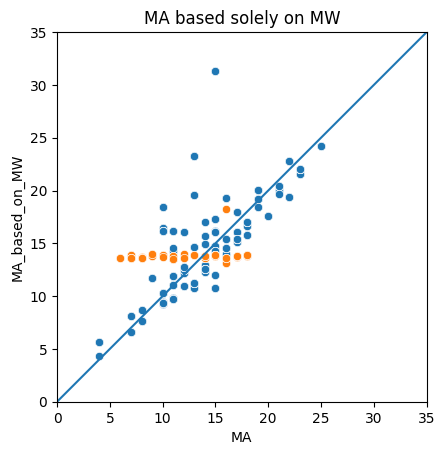

In [4]:
ax = sns.scatterplot(data=dfs['rest'], y='MA_based_on_MW', x='MA')
sns.scatterplot(data=dfs['300Da'], y='MA_based_on_MW', x='MA')
sns.lineplot(y=[0, 35], x=[0, 35])
ax.title.set_text('MA based solely on MW')
ax.set_aspect('equal')
ax.set_ylim(0, 35)
ax.set_xlim(0, 35)

In [5]:
# The dataset contains a lot of duplicates, so we need to remove them
best_case_rest = (
    dfs["rest"]
    .groupby("SMILES")
    .apply(lambda df: df.sort_values("MA (mean est.)").iloc[0])
)
best_case_300Da = (
    dfs["300Da"]
    .groupby("SMILES")
    .apply(lambda df: df.sort_values("MA (mean est.)").iloc[0])
)

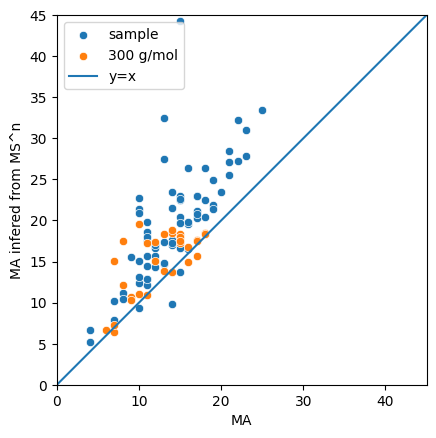

In [14]:
ax = sns.scatterplot(data=best_case_rest, y='MA (mean est.)', x='MA')
sns.scatterplot(data=best_case_300Da, y='MA (mean est.)', x='MA')
sns.lineplot(y=[0, 45], x=[0, 45])
ax.set_aspect('equal')
ax.set_xlim(0, 45)
ax.set_ylim(0, 45)
ax.set_ylabel('MA infered from MS^n')
ax.legend(['sample','300 g/mol','y=x'])
# ax.set_xlim
plt.savefig('recursive_ma.svg', format='svg')

In [7]:
# correaltion of the whole dataset

df_all = pd.concat([best_case_rest, best_case_300Da])
from scipy.stats import pearsonr

print(
    "Pearson correlation coeficient is: "
    f"{round(pearsonr(df_all['MA (mean est.)'], df_all.MA)[0],2)}"
)

Pearson correlation coeficient is: 0.73


In [8]:
best_case_rest.index.name = None
best_case_300Da.index.name = None
nmr_ir_exp = pd.read_csv("nmr_ir_exp.csv")  # read experimental IR and NMR data
nmr_ir_exp["SMILES"] = nmr_ir_exp.inchi.apply(
    lambda x: Chem.CanonSmiles(Chem.MolToSmiles(Chem.MolFromInchi(x)))
)
combined = pd.merge(nmr_ir_exp, best_case_rest, on="SMILES", how="left")
combined["exact_mw"] = combined.SMILES.apply(
    lambda x: Descriptors.ExactMolWt(Chem.MolFromSmiles(x))
)

In [9]:
for index in combined.index:
    current_row = combined.loc[index]
    if not current_row["MA (mean est.)"] > 0:
        # for case where MS^n is not available
        combined.loc[index, "MS_infered_MA"] = ms2ma(current_row["exact_mw"])
    else:
        # in case MS_n is available
        combined.loc[index, "MS_infered_MA"] = current_row["MA (mean est.)"]

    # in case of discrepancy of therotical MA, choose lower value
    # (as the Go algoritm can only overestimate the MA)
    if current_row["MA"] < current_row["assembly_index_x"]:
        combined.loc[index, "MA_consensus"] = current_row["MA"]
    else:
        combined.loc[index, "MA_consensus"] = current_row["assembly_index_x"]

In [10]:
# simple avarage of all three methods
combined['all_exp_MA2'] = (combined.NMR_MA + combined.IR_MA + combined['MS_infered_MA']) / 3

 Pearson correlation coefficient for all experiments is: 0.883
 Pearson correlation coefficient for MS only experiments is: 0.6776
 Pearson correlation coefficient for NMR only experiments is: 0.8262
 Pearson correlation coefficient for IR only experiments is: 0.8103


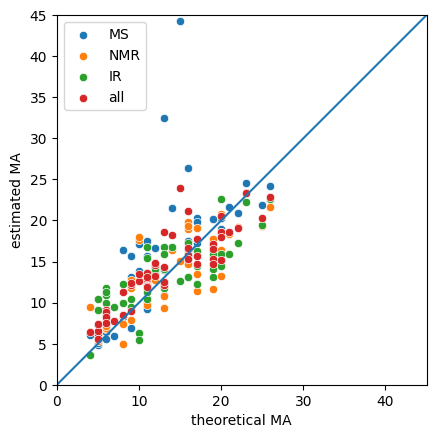

In [17]:
ax = sns.scatterplot(data=combined, y='MS_infered_MA', x='MA_consensus')
sns.scatterplot(data=combined, y='NMR_MA', x='MA_consensus')
sns.scatterplot(data=combined, y='IR_MA', x='MA_consensus')
sns.scatterplot(data=combined, y='all_exp_MA2', x='MA_consensus')
sns.lineplot(y=[0, 45], x=[0, 45])
ax.set_aspect('equal')
ax.set_xlim(0, 45)
ax.set_ylim(0, 45)
ax.set_ylabel('estimated MA')
ax.set_xlabel('theoretical MA')
ax.legend(['MS','NMR','IR','all'])
# ax.set_xlim
from scipy.stats import pearsonr

print(
    " Pearson correlation coefficient for all experiments is:",
    f"{round(pearsonr(combined.all_exp_MA2, combined.MA_consensus)[0],4)}\n",
    "Pearson correlation coefficient for MS only experiments is:",
    f"{round(pearsonr(combined.MS_infered_MA, combined.MA_consensus)[0],4)}\n",
    "Pearson correlation coefficient for NMR only experiments is:",
    f"{round(pearsonr(combined.NMR_MA, combined.MA_consensus)[0],4)}\n",
    "Pearson correlation coefficient for IR only experiments is:",
    f"{round(pearsonr(combined.IR_MA, combined.MA_consensus)[0],4)}",
)

/home/michael/miniconda3/envs/MMC/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


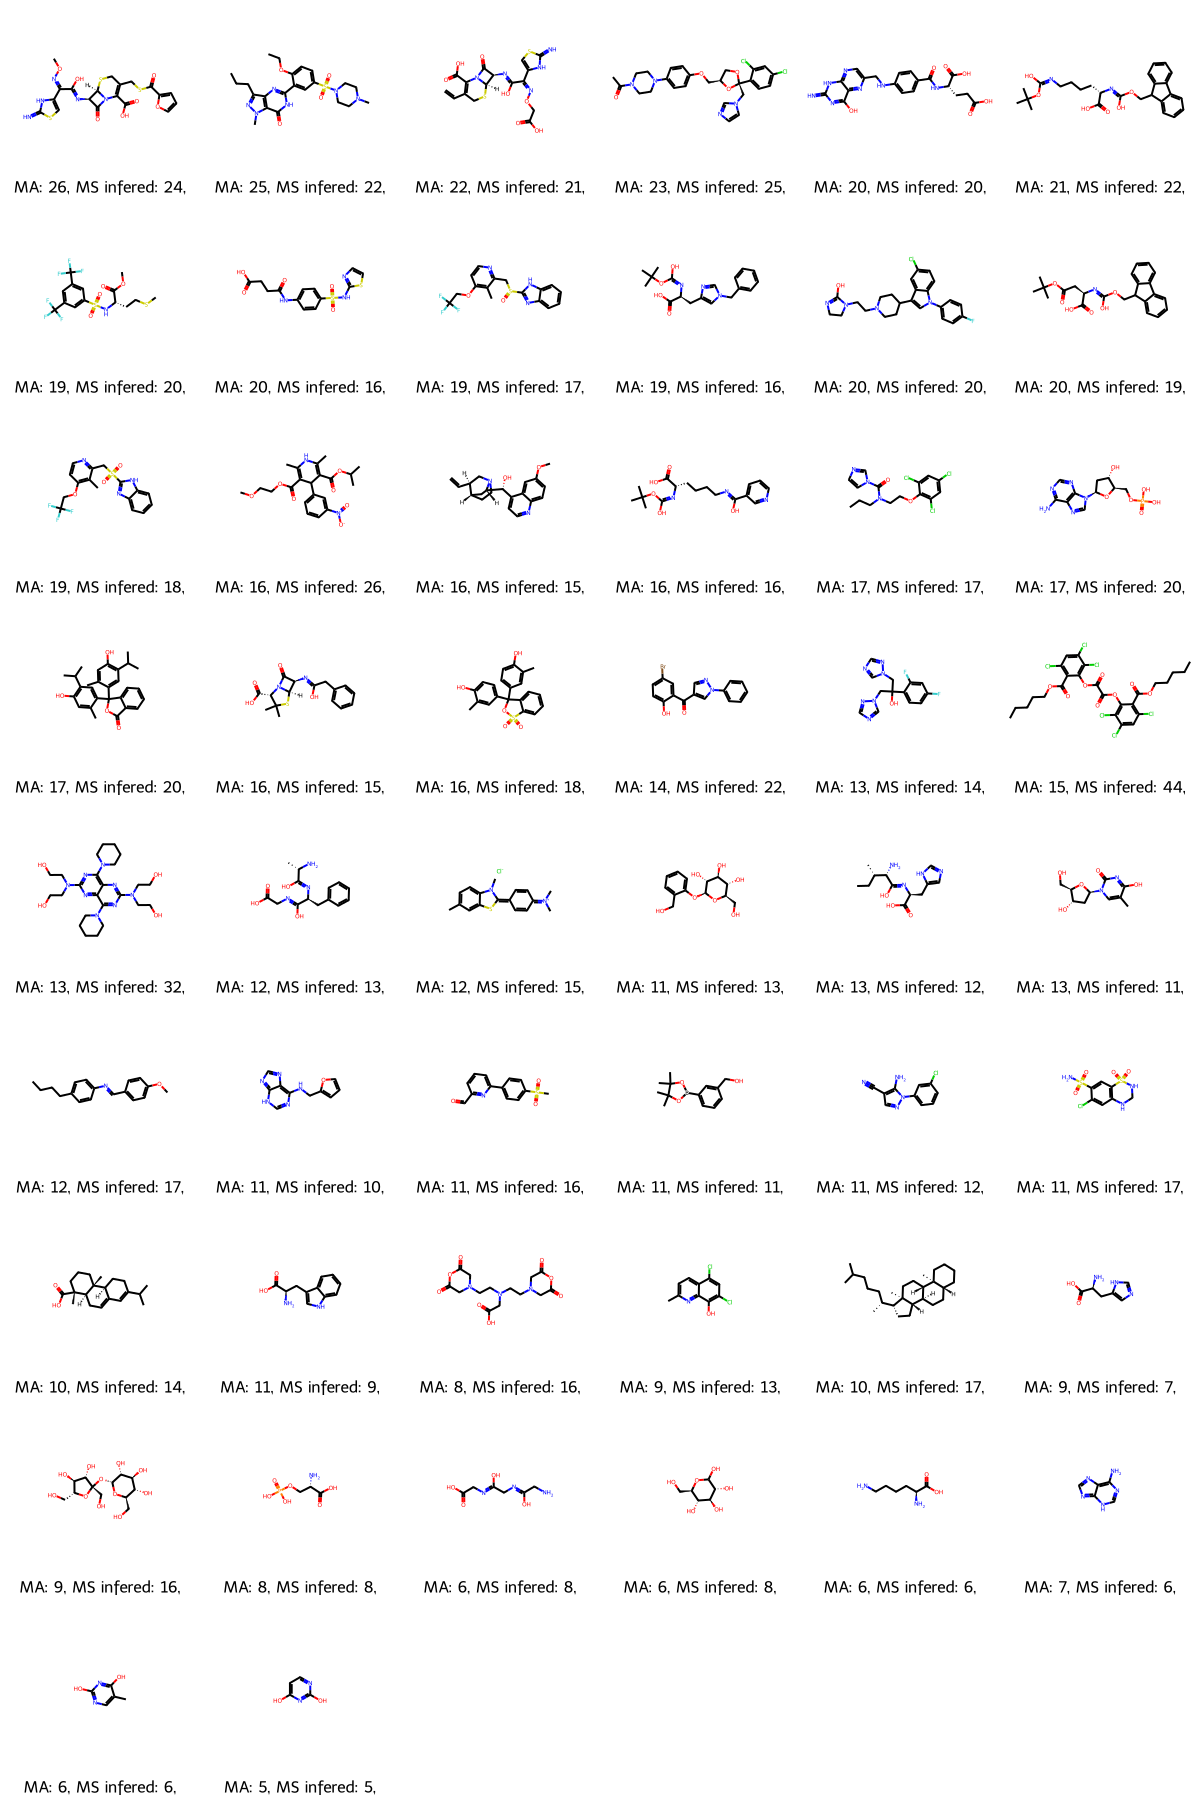

In [12]:
# Draw molecules from NMR,IR and MS dataset
from rdkit.Chem import Draw 

Draw.MolsToGridImage(
    [Chem.MolFromSmiles(x) for x in combined.SMILES],
    molsPerRow=6,
    subImgSize=(200, 200),
    legends=[
        f"MA: {x:.0f}, MS infered: {y:.0f},"
        for x, y in zip(combined.MA_consensus, combined.MS_infered_MA)
    ],
)

In [13]:
combined.to_csv("combined.csv", index=False)